In [1]:
import h5py
import numpy as np
import math
import scipy
import pywt
from scipy import signal
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline as spline
from scipy.fftpack import fft, fftshift ,ifft,rfft,fftfreq,rfftfreq
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Frequency=1/Time

In [2]:
BAM=['002','003','004','009','010','022','035','036','046','048','053','057','058','059','061','065','070','080','089','090','091','092','093','098','107','121','122','123','124','126','128']

Define functions to calculate different expected frequencies

For $q=1$

In [3]:
def f20(M,R6):
    return 8.943+4.059*M-1.332*R6-.358*(M**2)-.182*R6*M+.048*(R6**2)

In [4]:
def fspir(M,R8):
    return 6.264+1.929*M-.645*R8+.881*(M**2)-.311*R8*M+.03*(R8**2)

In [5]:
def fpeak(M,R6):
    return 13.822-0.576*M-1.375*R6+.479*(M**2)-.073*R6*M+.044*(R6**2)

For all cases

In [6]:
def f20_a(M,R6):
    return 9.586+4.09*M-1.427*R6+.048*(M**2)-.261*R6*M+.055*(R6**2)

In [7]:
def fspir_a(M,R8):
    return 5.846+1.75*M-.555*R8+1.002*(M**2)-.316*R8*M+.026*(R8**2)

In [8]:
def fpeak_a(M,R8):
    return 10.942-.369*M-.987*R8+1.095*(M**2)-.201*R8*M+.036*(R8**2)

Define functions to do the fft for our data  

In [9]:
def fre_do(x,y,mass):
    fd=fft(y)
    N=len(y)
    if (N % 2) == 1:
        N=N+1
    T=x[1]-x[0]
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))/mass
    fq=fftfreq(len(y))
    mask=fq>=0
    fd=2.0*(fd/N)
    fd=fd[mask]
    fd=abs(fd)
    return xf,fd
    

In [10]:
def analyze(rh,mass):
    
    
    
    rhM=rh[:,1]
    time=rh[:,0]
    
    peaks,prop=scipy.signal.find_peaks(abs(rhM))
    ampls=rhM[peaks]
    merg=np.amax(abs(ampls))
    merg=np.where(abs(ampls)==merg)
    merg=int(merg[0])
    t0=peaks[merg]
    
    ampl=rhM[t0:]
    tim=time[t0:]
    
    #ampl=rhM
    #tim=time
    
    tuk=signal.tukey(len(ampl),0.03)
    dat=ampl*tuk
    
    fq,fd=fre_do(tim,dat,mass)
    
    mx=np.where(fd==np.amax(fd))[0][0]
    freq=fq[mx]
    amp=fd[mx]
    fig=plt.figure()
    plt.plot((fq*Frequency),fd)
    plt.xlim(0,5500)
    return fq,fd,tim,dat,fig
    

Read metadata 

In [11]:

SLy=1
H4=2
MS1=3
MPA1=4
ALF2=5
MS1b=6
ms1b=6
ENG=7


In [12]:
q2 = np.zeros(31)
mas2=np.zeros(31)
eos=np.zeros(31)


i=0
for m in range(0,2):
    for k in range(0,10):
        for j in range(0,10):
            name = 'metadata/BAM:0%s%s%s.txt' %(m,k,j)
            try:
                f=open(name)
                lines=f.readlines() 
                exec(lines[10])
                q2[i] = id_mass_ratio
                exec(lines[8])
                mas2[i]=id_mass
                if i==0:
                    eos[i]=8 #by hand because 2H can not be given a value
                if i>0:
                    exec(lines[15])
                    eos[i]=id_eos
                
                i=i+1
            except OSError:
                pass



Isolate $q=1$ cases

In [13]:
index=[]
j=0
for i in range(len(q2)):
    if q2[i]==1:
        index.insert(j,i)
        j=j+1



Calculate chirp mass using the formula: $$ \left[\frac{q}{(1+q)^2}\right]^{3/5}M_{total} $$

In [14]:
Mc=pow(q2/pow(1+q2,2),3/5)*mas2

Find the radius for solar masses 1.6 and 1.8 for different EOS

In [15]:
m_r1=np.load('tid_def/SLy.npy')
m_r2=np.load('tid_def/H4.npy')
m_r3=np.load('tid_def/MS1.npy')
m_r4=np.load('tid_def/MPA1.npy')
m_r5=np.load('tid_def/ALF2.npy')
m_r6=np.load('tid_def/MS1b.npy')
m_r7=np.load('tid_def/ENG.npy')
m_r8=np.load('tid_def/2H.npy')


#k_l1=np.load('tid_def/k_l_SLy.npy')
#k_l2=np.load('tid_def/k_l_H4.npy')
#k_l3=np.load('tid_def/k_l_MS1.npy')
#k_l4=np.load('tid_def/k_l_MPA1.npy')
#k_l5=np.load('tid_def/k_l_ALF2.npy')
#k_l6=np.load('tid_def/k_l_MS1b.npy')
#k_l7=np.load('tid_def/k_l_ENG.npy')
#k_l8=np.load('tid_def/k_l_2H.npy')

Find the $R_{1.6}$ , $R_{1.8}$ for every binary 

In [16]:
mx=np.amax(m_r1[0])
idx=np.where(m_r1[0]==mx)
idx=idx[0][0]
#cs1=spline(m_r1[0][1:idx],k_l1[0][1:idx])
cs11=spline(m_r1[0][1:idx],m_r1[1][1:idx])

mx=np.amax(m_r2[0])
idx=np.where(m_r2[0]==mx)
idx=idx[0][0]
#cs2=spline(m_r2[0][1:idx],k_l2[0][1:idx])
cs21=spline(m_r2[0][1:idx],m_r2[1][1:idx])

mx=np.amax(m_r3[0])
idx=np.where(m_r3[0]==mx)
idx=idx[0][0]
#cs3=spline(m_r3[0][1:idx],k_l3[0][1:idx])
cs31=spline(m_r3[0][1:idx],m_r3[1][1:idx])

mx=np.amax(m_r4[0])
idx=np.where(m_r4[0]==mx)
idx=idx[0][0]
#cs4=spline(m_r4[0][1:idx],k_l4[0][1:idx])
cs41=spline(m_r4[0][1:idx],m_r4[1][1:idx])

mx=np.amax(m_r5[0])
idx=np.where(m_r5[0]==mx)
idx=idx[0][0]
#cs5=spline(m_r5[0][1:idx],k_l5[0][1:idx])
cs51=spline(m_r5[0][1:idx],m_r5[1][1:idx])

mx=np.amax(m_r6[0])
idx=np.where(m_r6[0]==mx)
idx=idx[0][0]
#cs6=spline(m_r6[0][1:idx],k_l6[0][1:idx])
cs61=spline(m_r6[0][1:idx],m_r6[1][1:idx])

mx=np.amax(m_r7[0])
idx=np.where(m_r7[0]==mx)
idx=idx[0][0]
#cs7=spline(m_r7[0][1:idx],k_l7[0][1:idx])
cs71=spline(m_r7[0][1:idx],m_r7[1][1:idx])

mx=np.amax(m_r8[0])
idx=np.where(m_r8[0]==mx)
idx=idx[0][0]
#cs8=spline(m_r8[0][1:idx],k_l8[0][1:idx])
cs81=spline(m_r8[0][1:idx],m_r8[1][1:idx])

In [17]:
r68=np.zeros((len(BAM),2))

for i in range(len(BAM)):
    if eos[i]==1:
        r68[i,0]=cs11(1.6)*Length/1.0e5
        r68[i,1]=cs11(1.8)*Length/1.0e5
        
    elif eos[i]==2:
        r68[i,0]=cs21(1.6)*Length/1.0e5
        r68[i,1]=cs21(1.8)*Length/1.0e5
    elif eos[i]==3:
        r68[i,0]=cs31(1.6)*Length/1.0e5
        r68[i,1]=cs31(1.8)*Length/1.0e5
        
    elif eos[i]==4:
        r68[i,0]=cs41(1.6)*Length/1.0e5
        r68[i,1]=cs41(1.8)*Length/1.0e5
        
    elif eos[i]==5:
        r68[i,0]=cs51(1.6)*Length/1.0e5
        r68[i,1]=cs51(1.8)*Length/1.0e5
        
    elif eos[i]==6:
        r68[i,0]=cs61(1.6)*Length/1.0e5
        r68[i,1]=cs61(1.8)*Length/1.0e5
        
    elif eos[i]==7:
        r68[i,0]=cs71(1.6)*Length/1.0e5
        r68[i,1]=cs71(1.8)*Length/1.0e5
        
    elif eos[i]==8:
        r68[i,0]=cs81(1.6)*Length/1.0e5
        r68[i,1]=cs81(1.8)*Length/1.0e5
        
    

Calculate the different frequencies for $q=1$

In [18]:
f_2=np.zeros(len(BAM))
f_s=np.zeros(len(BAM))
f_p=np.zeros(len(BAM))
for i in index:
    f_2[i]=f20(Mc[i],r68[i,0])
    f_p[i]=fpeak(Mc[i],r68[i,0])
    f_s[i]=fspir(Mc[i],r68[i,1])

Do the analysis and produce the plots for $q=1$

data/BAM:0002.h5


/home/jannis/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


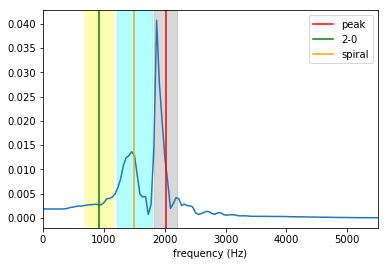

_____________________________________________________


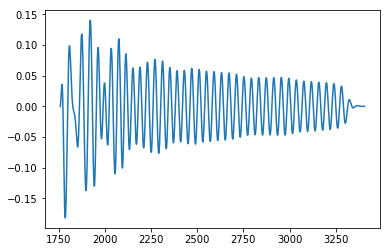

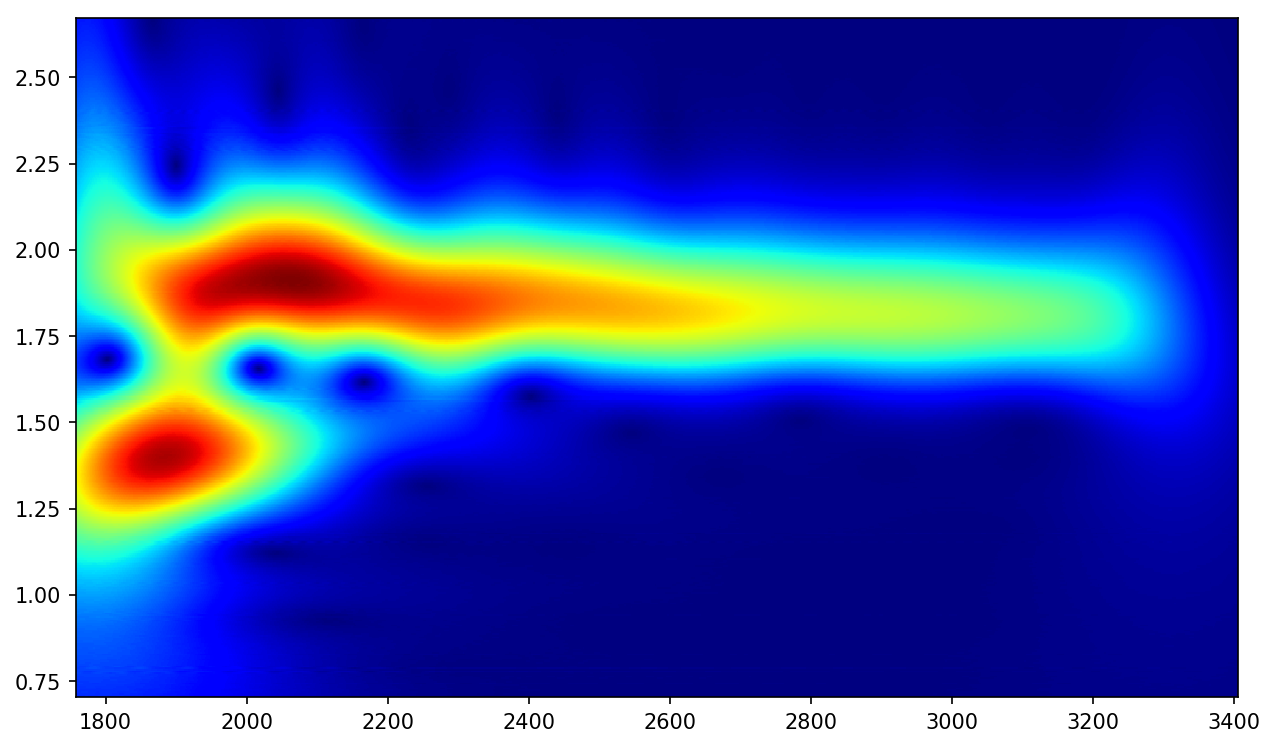

data/BAM:0003.h5


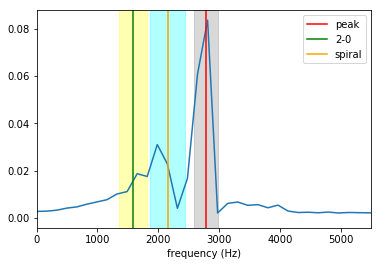

_____________________________________________________


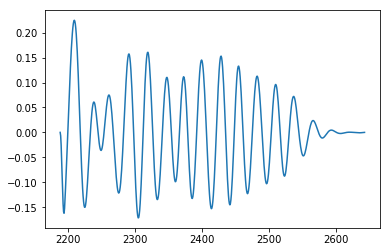

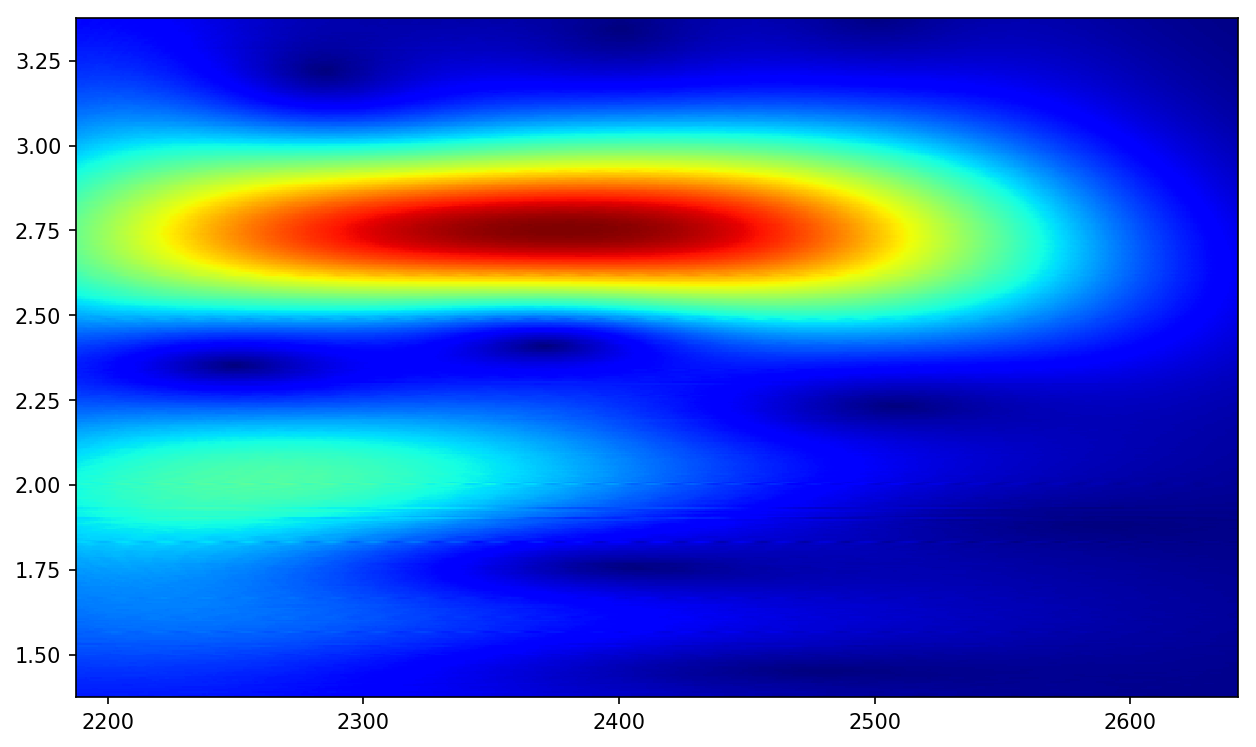

data/BAM:0004.h5


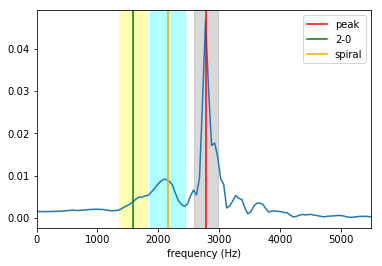

_____________________________________________________


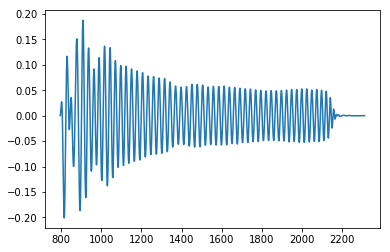

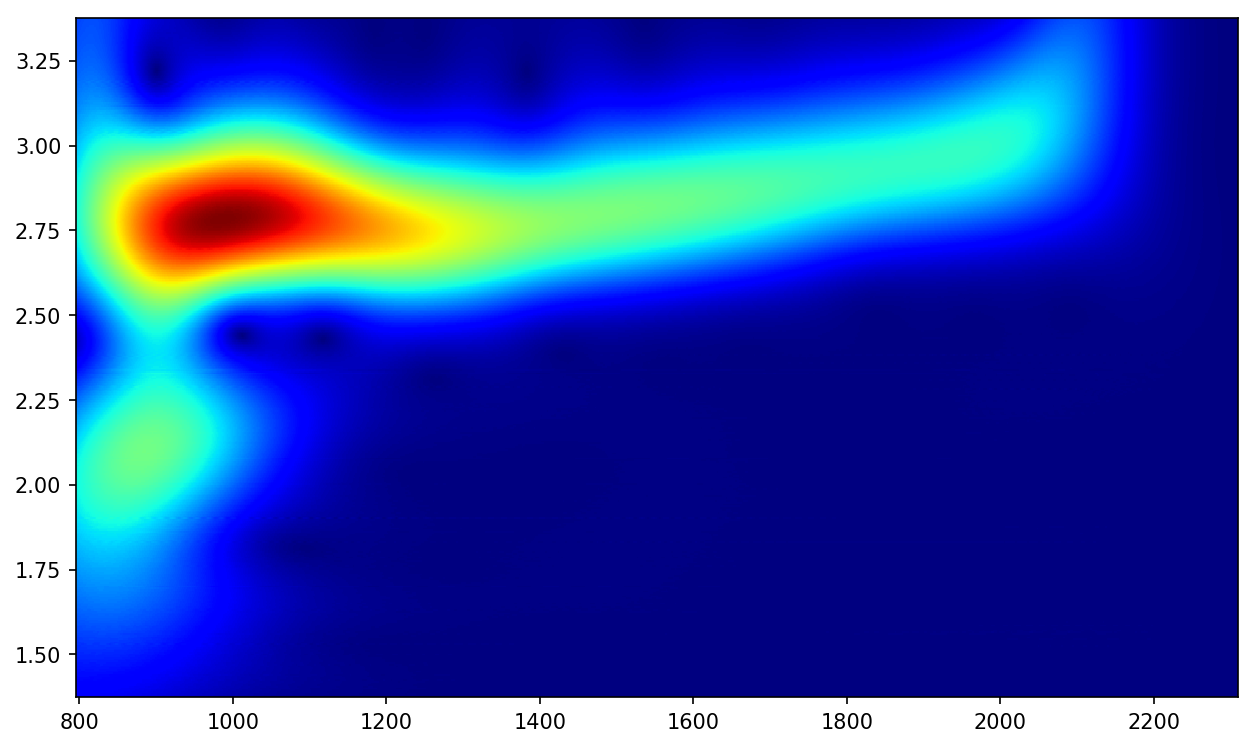

data/BAM:0022.h5


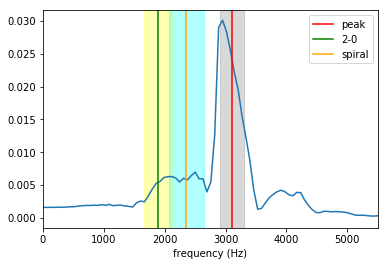

_____________________________________________________


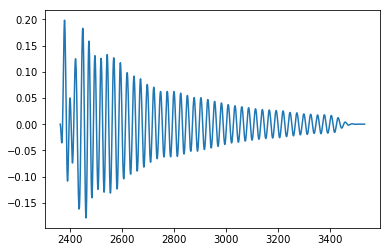

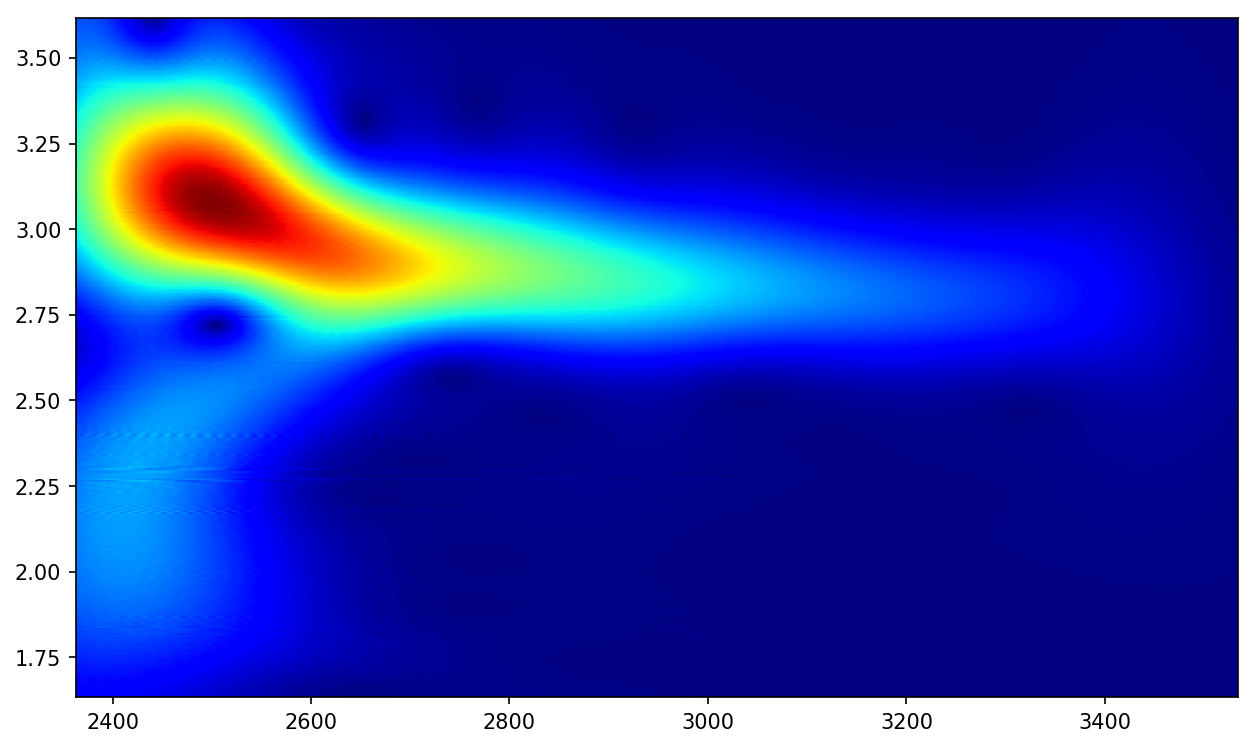

data/BAM:0035.h5


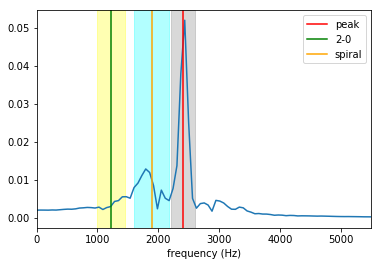

_____________________________________________________


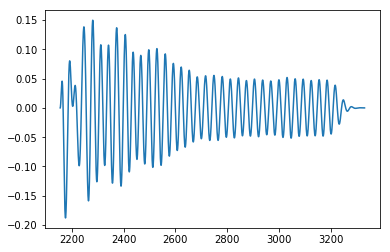

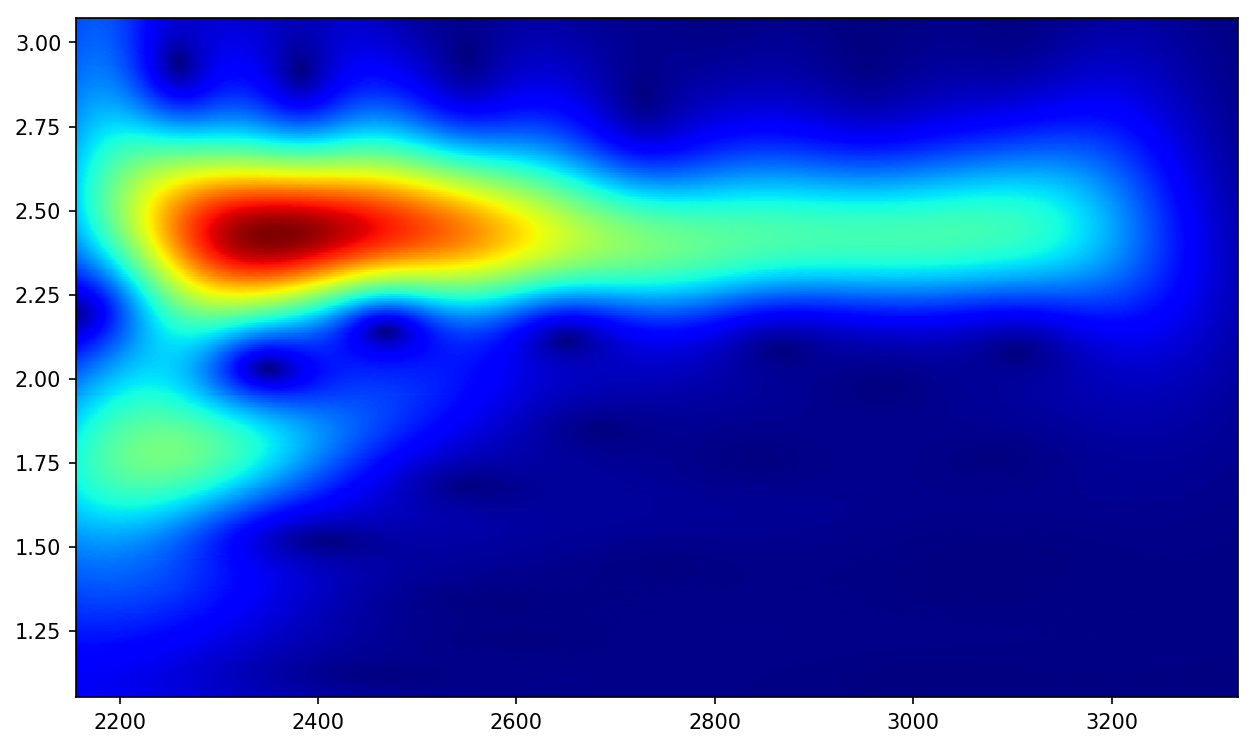

data/BAM:0036.h5


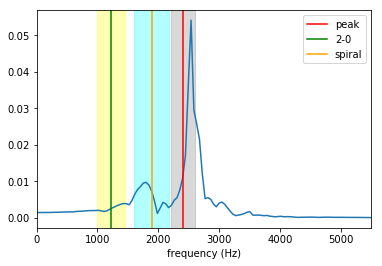

_____________________________________________________


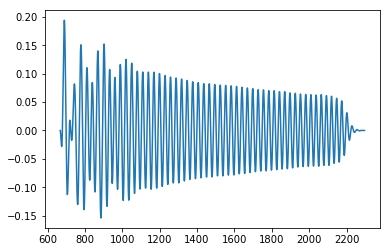

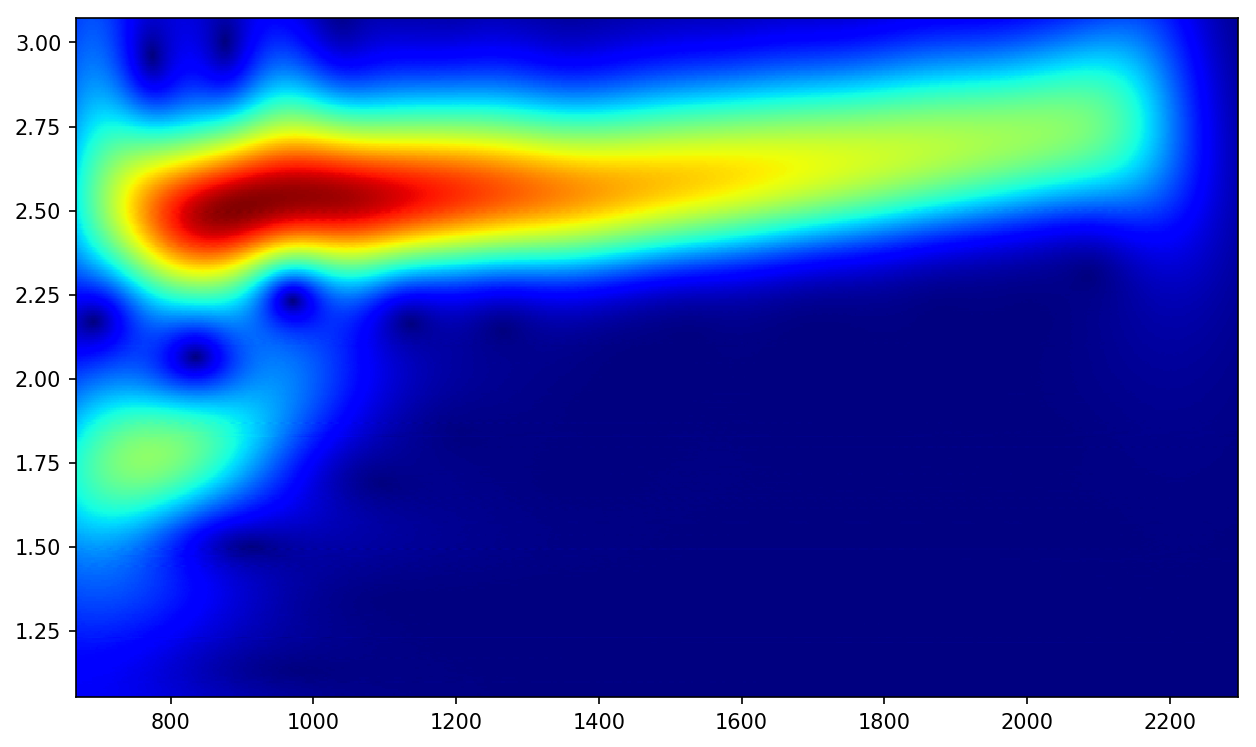

data/BAM:0058.h5


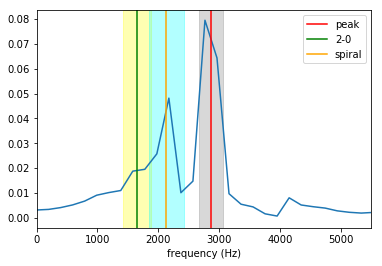

_____________________________________________________


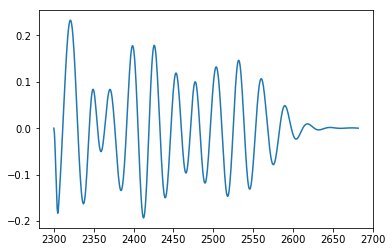

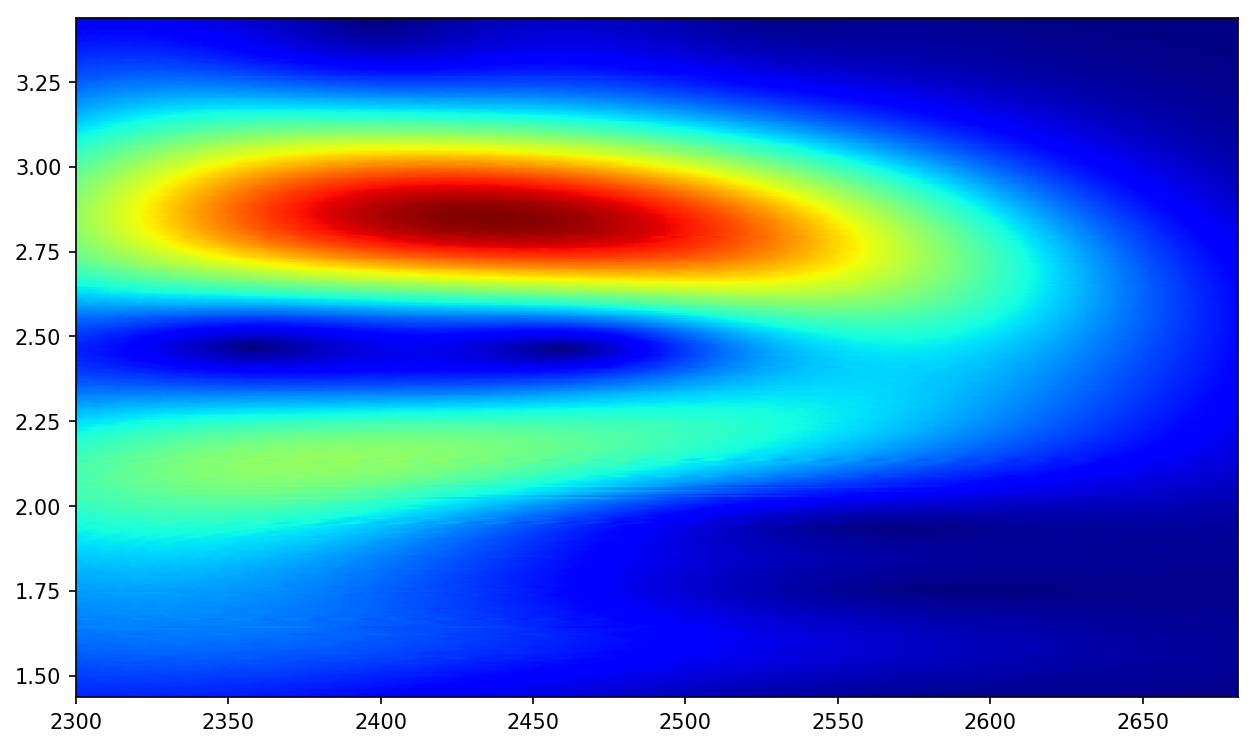

data/BAM:0061.h5


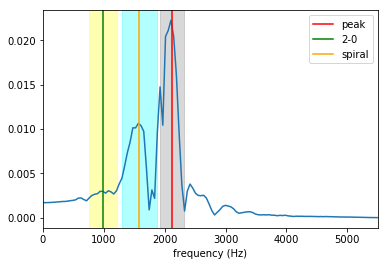

_____________________________________________________


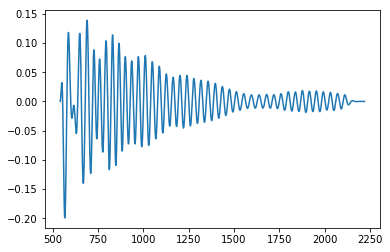

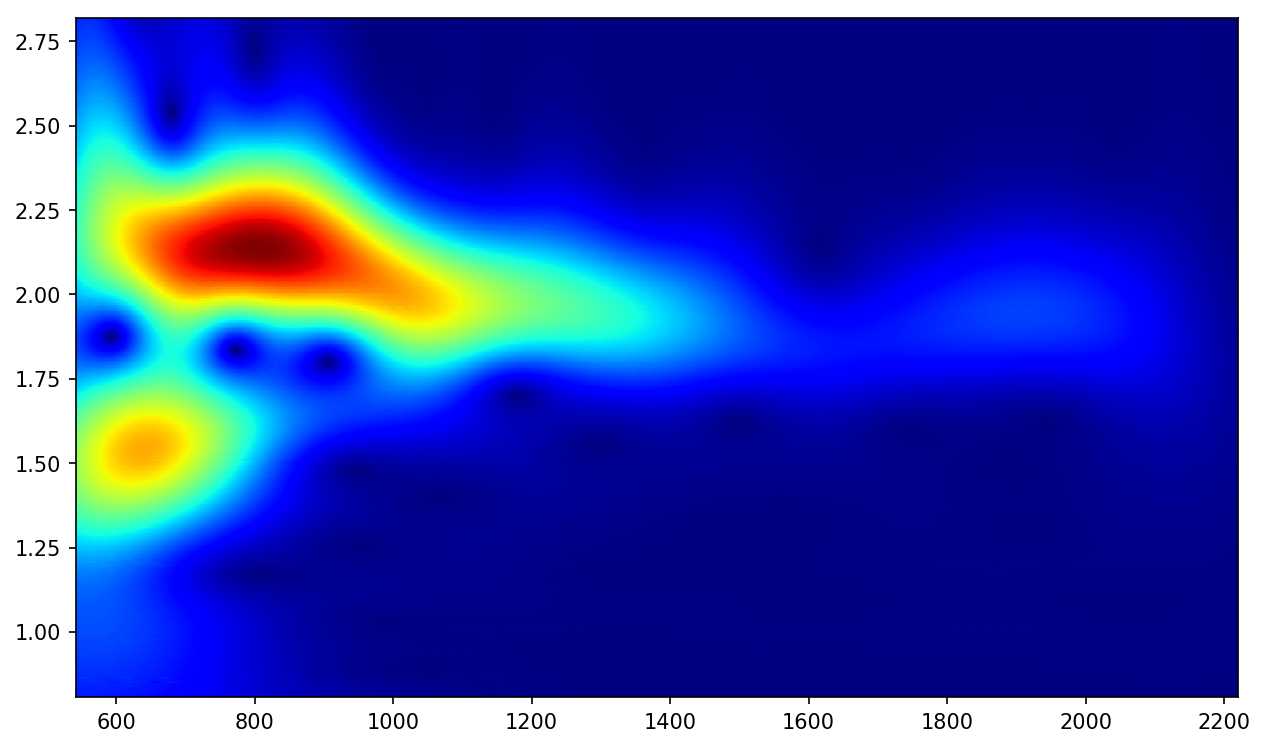

data/BAM:0065.h5


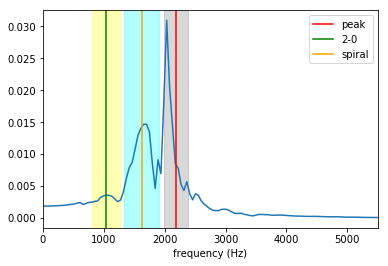

_____________________________________________________


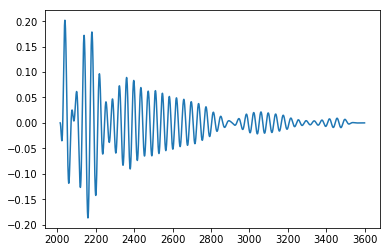

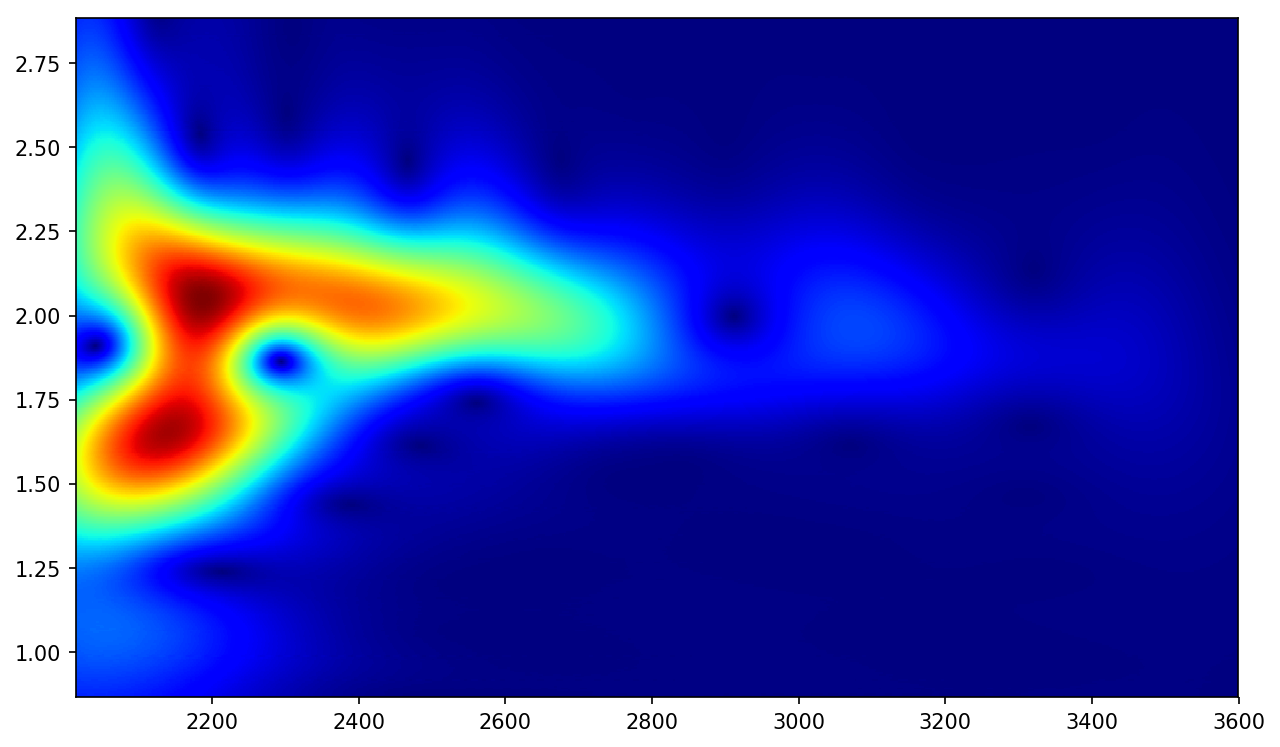

data/BAM:0070.h5


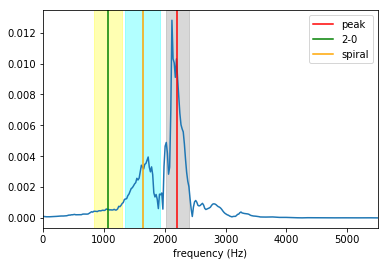

_____________________________________________________


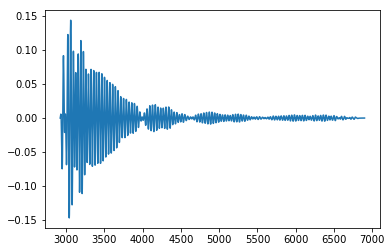

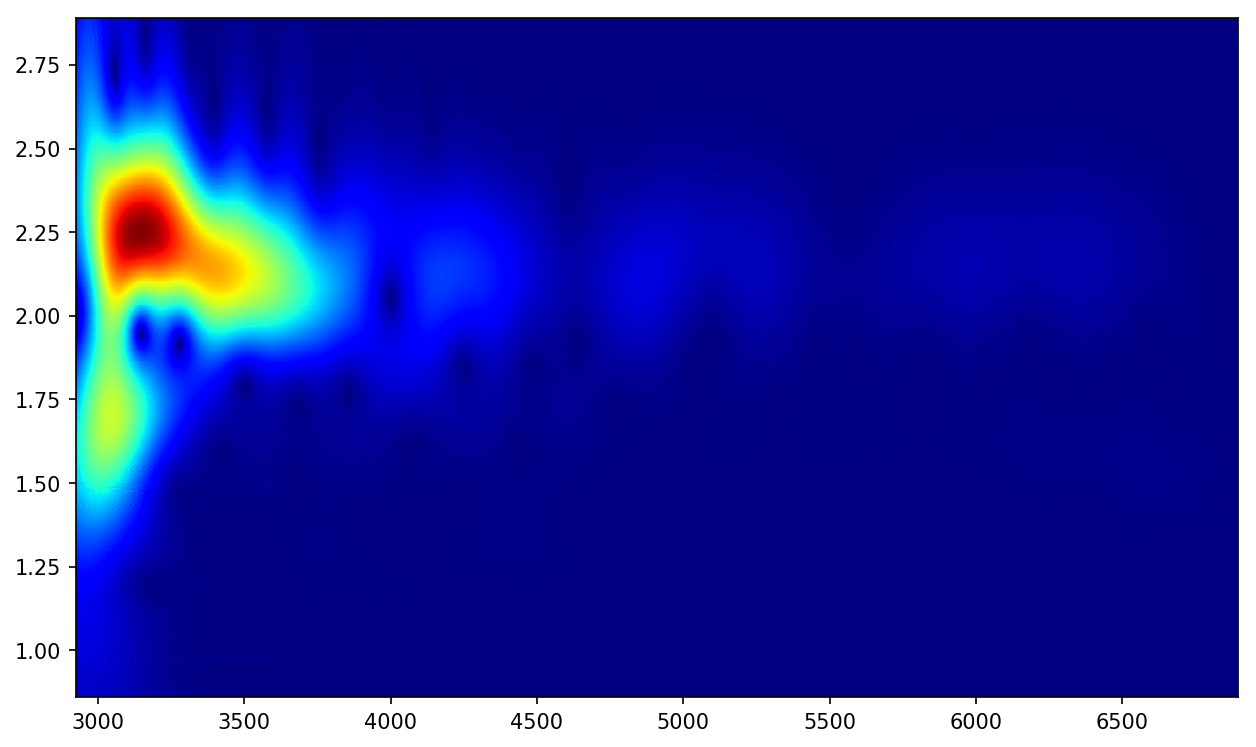

data/BAM:0090.h5


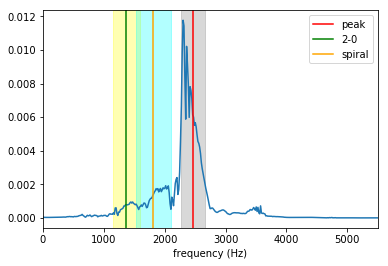

_____________________________________________________


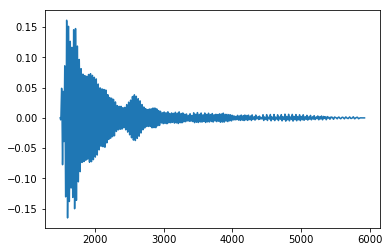

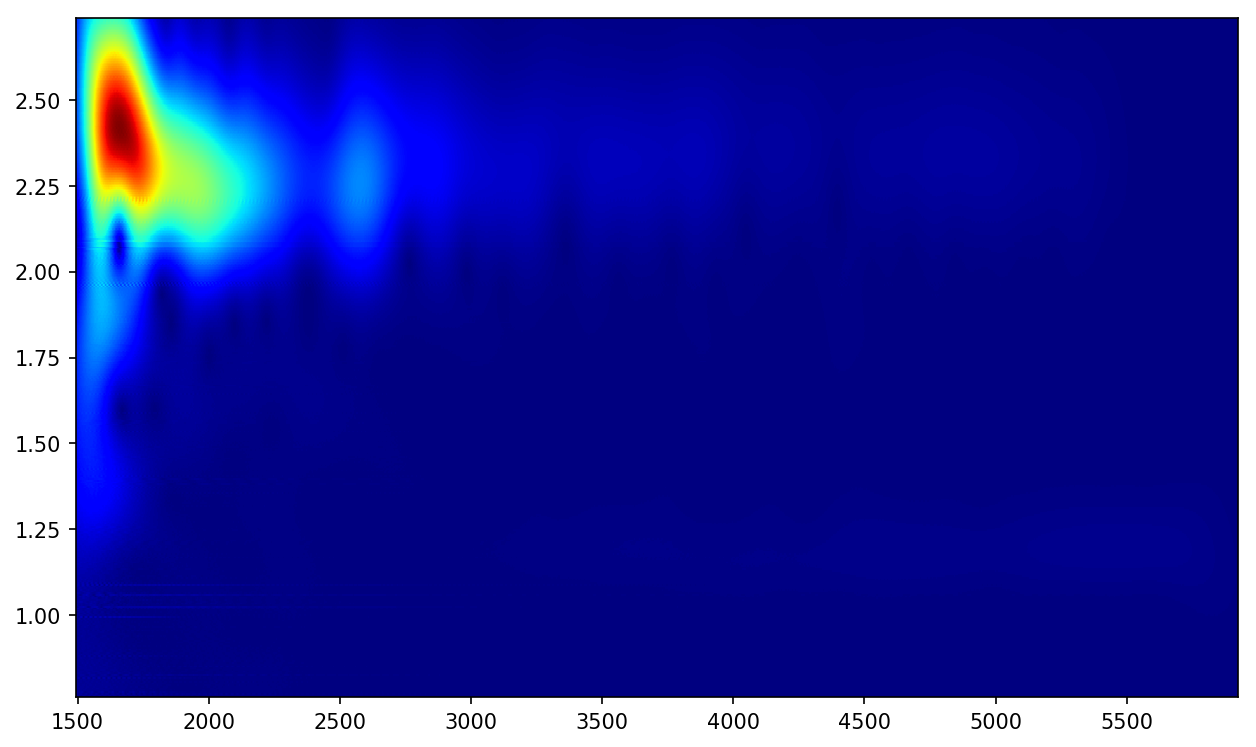

data/BAM:0092.h5


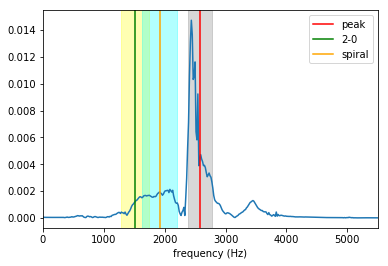

_____________________________________________________


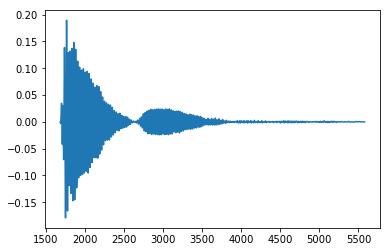

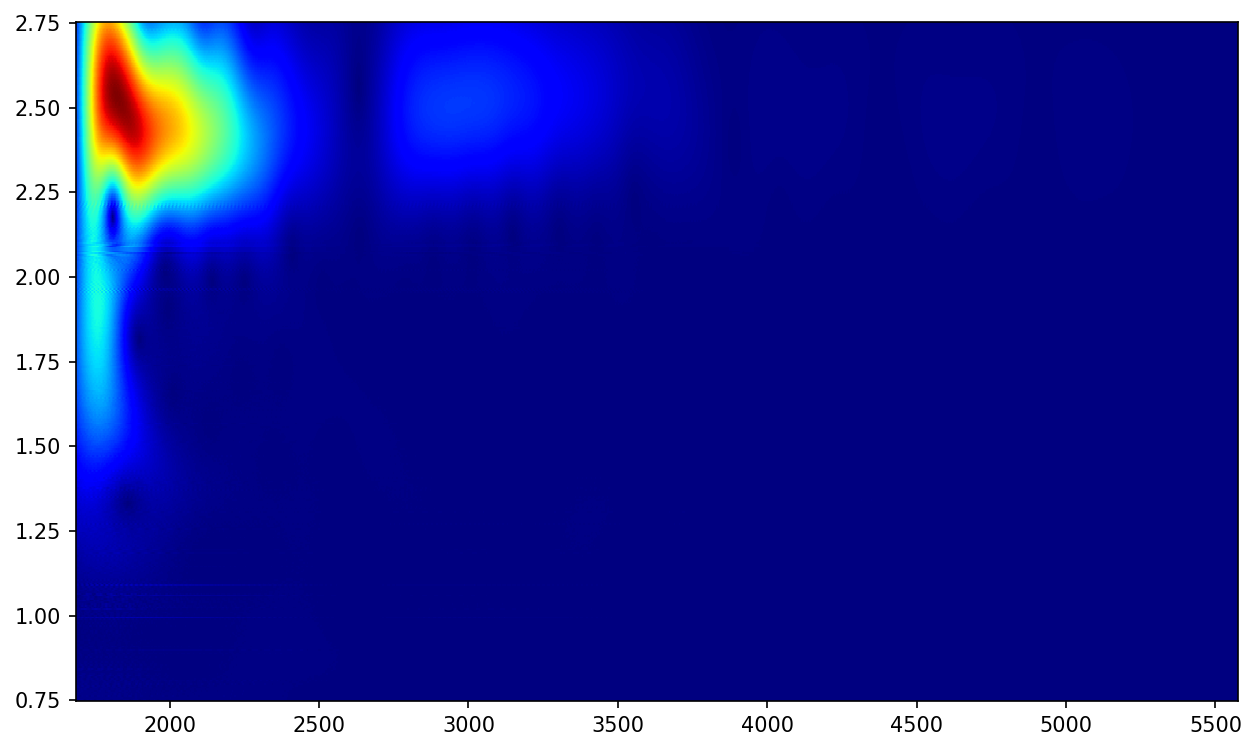

data/BAM:0098.h5


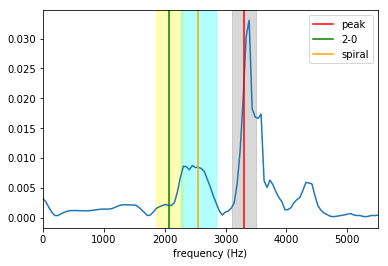

_____________________________________________________


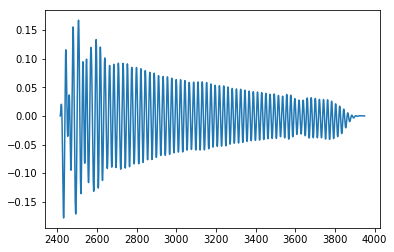

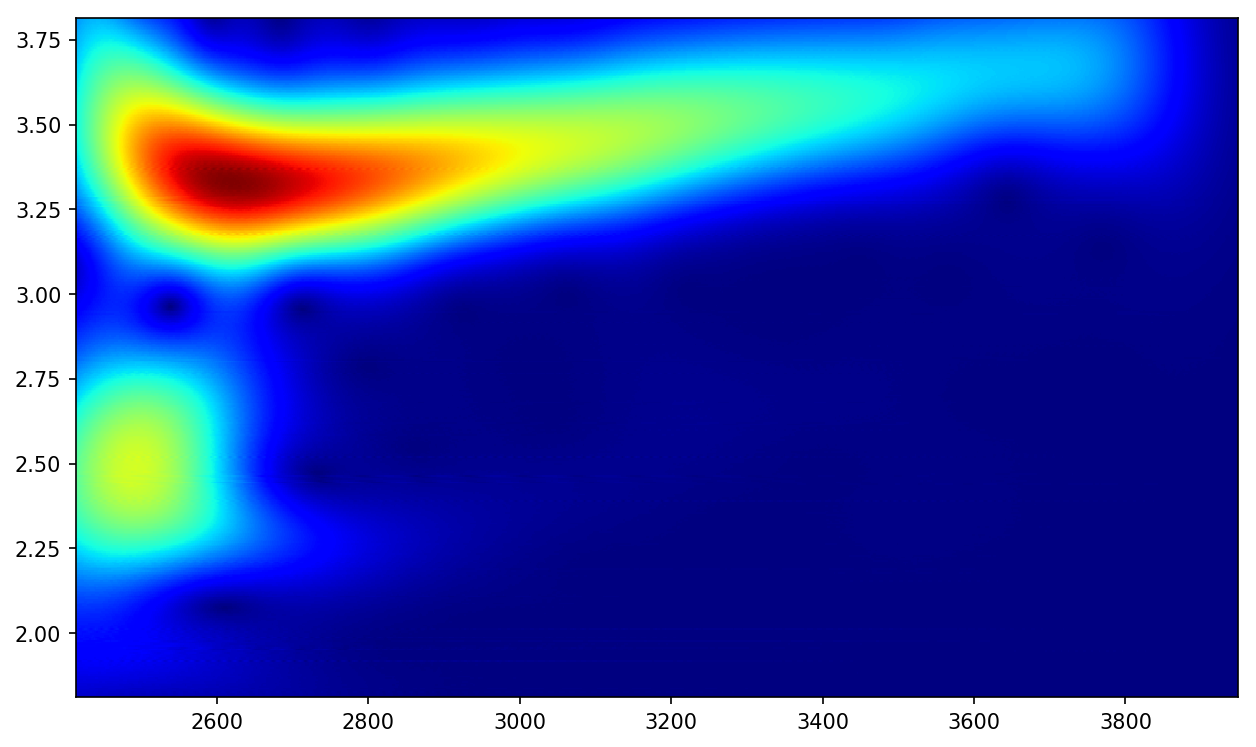

In [19]:

for i in index:
    name = 'data/BAM:0'+BAM[i]+'.h5' 
    print(name)
    file=h5py.File(name,'r')
    dat = list(file["/rh_22"])
    rh = np.array(file["/rh_22/%s" %dat[-1]])
    freq,amp,time,dat,fig1=analyze(rh,mas2[i])
    ax=plt.subplot()
    ax.axvline(x=(f_p[i]*Mc[i])*1000,color='r',label='peak')
    ax.axvspan((f_p[i]*Mc[i])*1000-196, (f_p[i]*Mc[i])*1000+196, alpha=0.3, color='grey')
    ax.axvline(x=(f_2[i]*Mc[i])*1000,color='g',label='2-0')
    ax.axvspan((f_2[i]*Mc[i])*1000-229, (f_2[i]*Mc[i])*1000+229, alpha=0.3, color='yellow')
    ax.axvline((f_s[i]*Mc[i])*1000,color='orange',label='spiral') 
    ax.axvspan((f_s[i]*Mc[i])*1000-286, (f_s[i]*Mc[i])*1000+286, alpha=0.3, color='cyan')
    plt.xlabel('frequency (Hz)')
    plt.legend()
    plt.show()
    print('_____________________________________________________')
    
    plt.plot(time,dat)
    plt.show()
    fc = f_p[i]                                                                
    dt=(time[1]-time[0])*Time*1000*mas2[i]
    band = 2.5                                                         
    wavelet = 'cmor'+str(band)+'-'+str(fc)                        
    widths = fc/np.linspace(fc-1.0, fc+1.0, 400)/dt        
    cwtmatr, freqs = pywt.cwt(dat, widths, wavelet, dt)    
    power = abs(cwtmatr)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.pcolormesh(time, freqs, power,cmap='jet')
    plt.show()
    

data/BAM:0002.h5


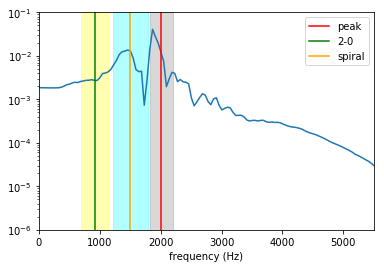

_____________________________________________________
data/BAM:0003.h5


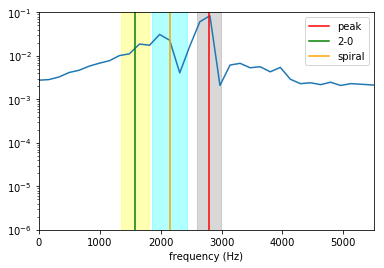

_____________________________________________________
data/BAM:0004.h5


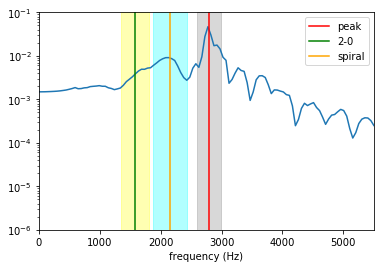

_____________________________________________________
data/BAM:0022.h5


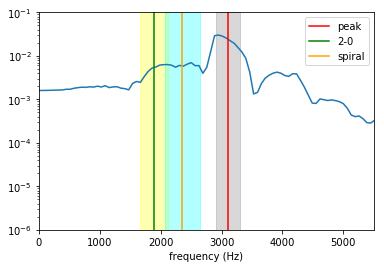

_____________________________________________________
data/BAM:0035.h5


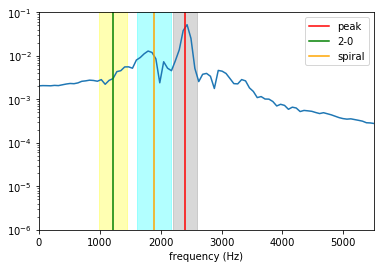

_____________________________________________________
data/BAM:0036.h5


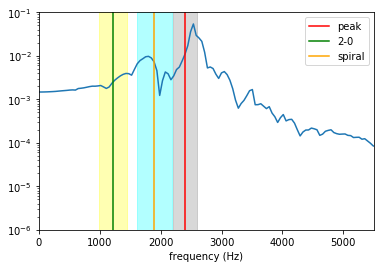

_____________________________________________________
data/BAM:0058.h5


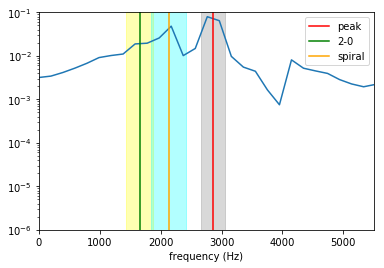

_____________________________________________________
data/BAM:0061.h5


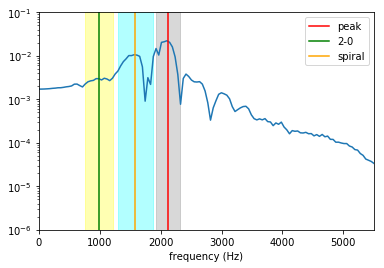

_____________________________________________________
data/BAM:0065.h5


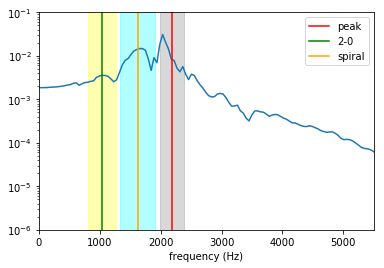

_____________________________________________________
data/BAM:0070.h5


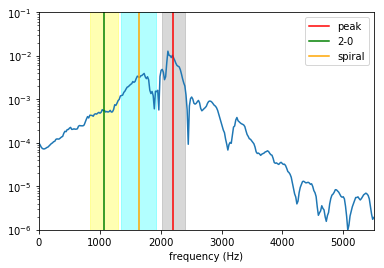

_____________________________________________________
data/BAM:0090.h5


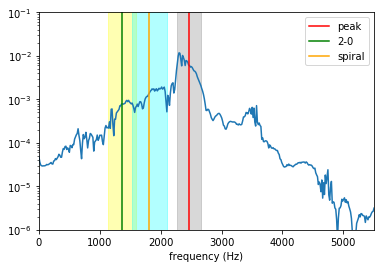

_____________________________________________________
data/BAM:0092.h5


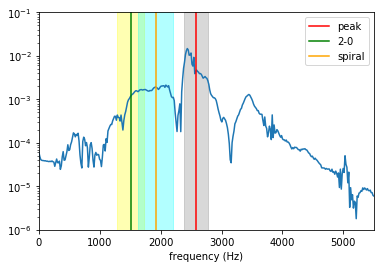

_____________________________________________________
data/BAM:0098.h5


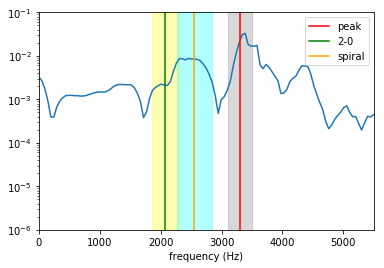

_____________________________________________________


In [20]:

for i in index:
    name = 'data/BAM:0'+BAM[i]+'.h5' 
    print(name)
    file=h5py.File(name,'r')
    dat = list(file["/rh_22"])
    rh = np.array(file["/rh_22/%s" %dat[-1]])
    freq,amp,time,dat,fig1=analyze(rh,mas2[i])
    ax=plt.subplot()
    ax.axvline(x=(f_p[i]*Mc[i])*1000,color='r',label='peak')
    ax.axvspan((f_p[i]*Mc[i])*1000-196, (f_p[i]*Mc[i])*1000+196, alpha=0.3, color='grey')
    ax.axvline(x=(f_2[i]*Mc[i])*1000,color='g',label='2-0')
    ax.axvspan((f_2[i]*Mc[i])*1000-229, (f_2[i]*Mc[i])*1000+229, alpha=0.3, color='yellow')
    ax.axvline((f_s[i]*Mc[i])*1000,color='orange',label='spiral') 
    ax.axvspan((f_s[i]*Mc[i])*1000-286, (f_s[i]*Mc[i])*1000+286, alpha=0.3, color='cyan')
    plt.xlabel('frequency (Hz)')
    plt.legend()
    plt.yscale('log')
    plt.ylim(10**(-6),10**(-1))
    plt.show()
    print('_____________________________________________________')
    

Calculate the different frequencies for all cases

In [21]:
f_2_a=np.zeros(len(BAM))
f_s_a=np.zeros(len(BAM))
f_p_a=np.zeros(len(BAM))
for i in range(len(BAM)):
    f_2_a[i]=f20_a(Mc[i],r68[i,0])
    f_p_a[i]=fpeak_a(Mc[i],r68[i,0])
    f_s_a[i]=fspir_a(Mc[i],r68[i,1])

Do the analysis and produce the plots for all cases

data/BAM:0002.h5


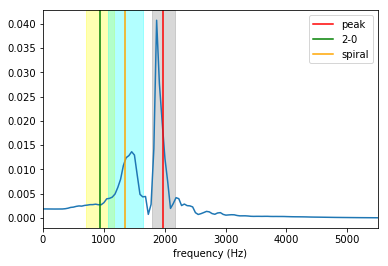

_____________________________________________________
data/BAM:0003.h5


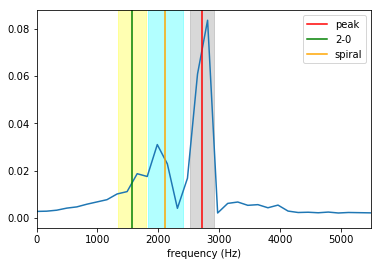

_____________________________________________________
data/BAM:0004.h5


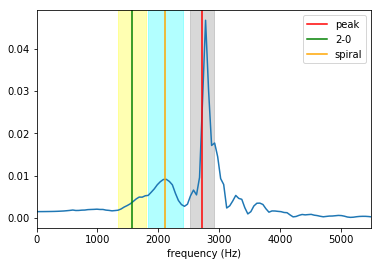

_____________________________________________________
data/BAM:0009.h5


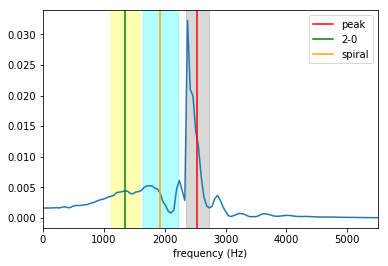

_____________________________________________________
data/BAM:0010.h5


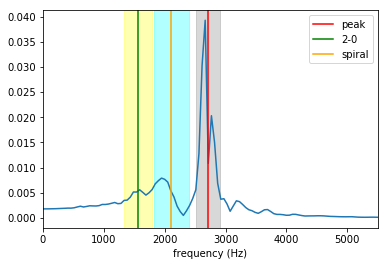

_____________________________________________________
data/BAM:0022.h5


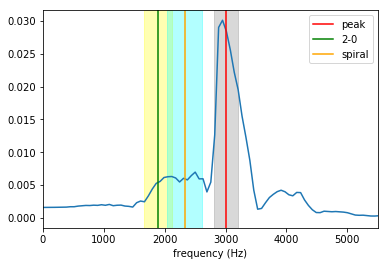

_____________________________________________________
data/BAM:0035.h5


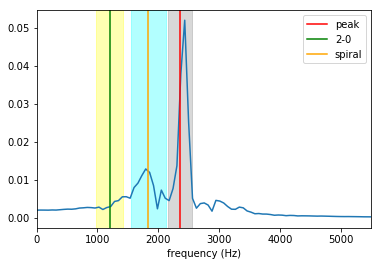

_____________________________________________________
data/BAM:0036.h5


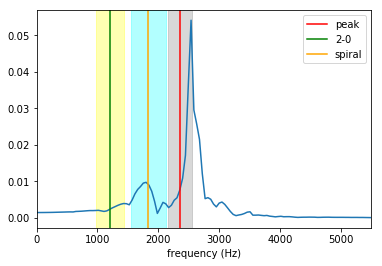

_____________________________________________________
data/BAM:0046.h5


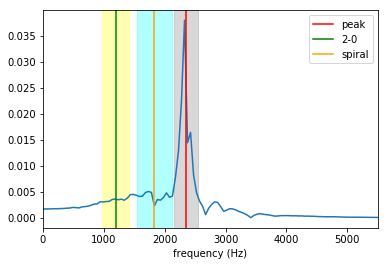

_____________________________________________________
data/BAM:0048.h5


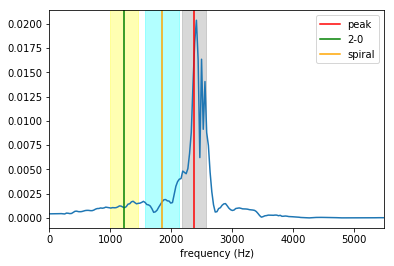

_____________________________________________________
data/BAM:0053.h5


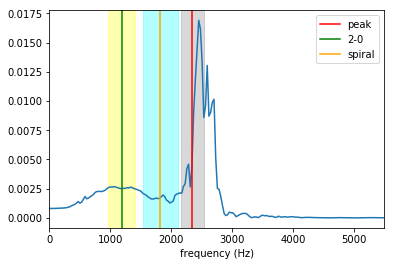

_____________________________________________________
data/BAM:0057.h5


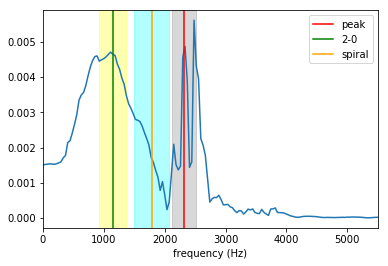

_____________________________________________________
data/BAM:0058.h5


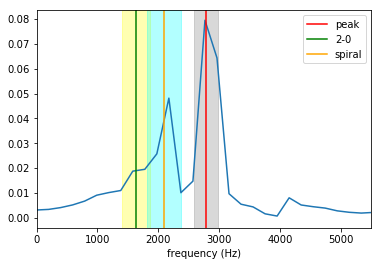

_____________________________________________________
data/BAM:0059.h5


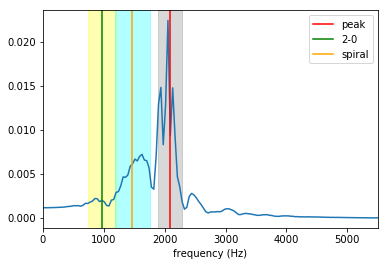

_____________________________________________________
data/BAM:0061.h5


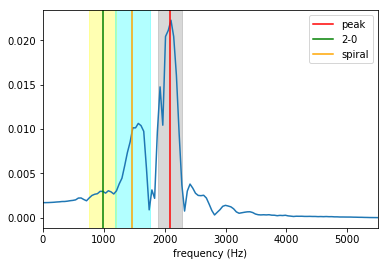

_____________________________________________________
data/BAM:0065.h5


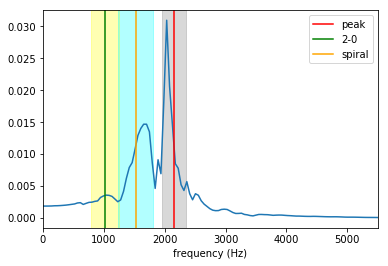

_____________________________________________________
data/BAM:0070.h5


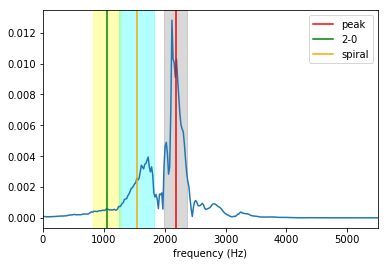

_____________________________________________________
data/BAM:0080.h5


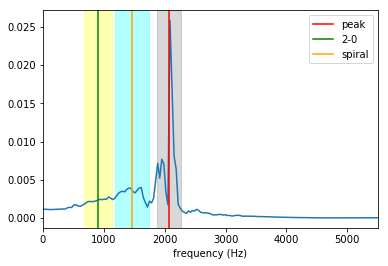

_____________________________________________________
data/BAM:0089.h5


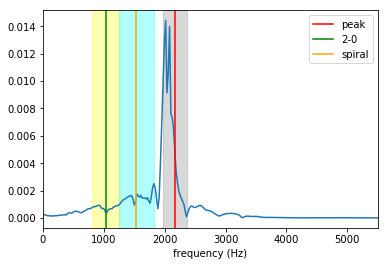

_____________________________________________________
data/BAM:0090.h5


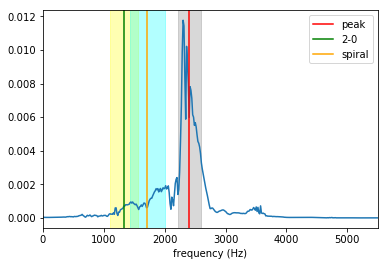

_____________________________________________________
data/BAM:0091.h5


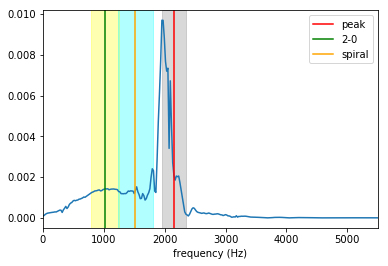

_____________________________________________________
data/BAM:0092.h5


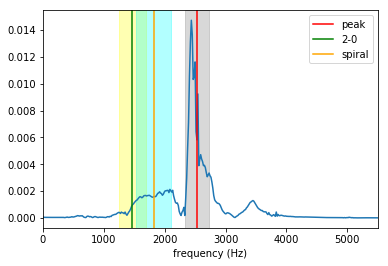

_____________________________________________________
data/BAM:0093.h5


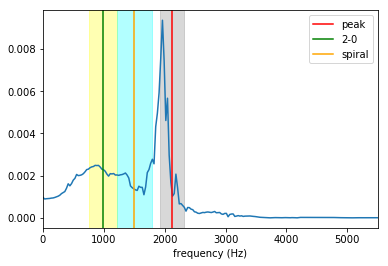

_____________________________________________________
data/BAM:0098.h5


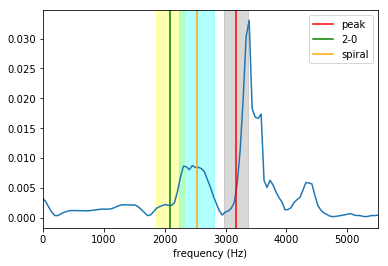

_____________________________________________________
data/BAM:0107.h5


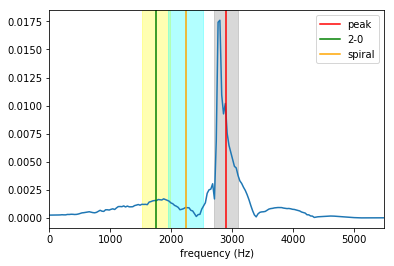

_____________________________________________________
data/BAM:0121.h5


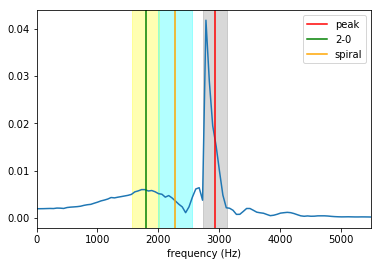

_____________________________________________________
data/BAM:0122.h5


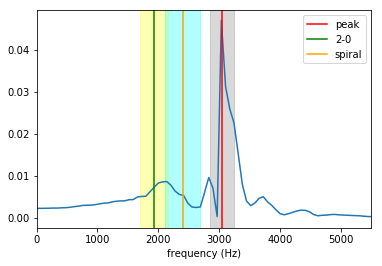

_____________________________________________________
data/BAM:0123.h5


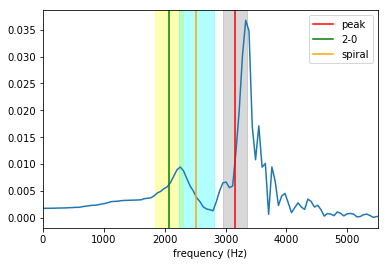

_____________________________________________________
data/BAM:0124.h5


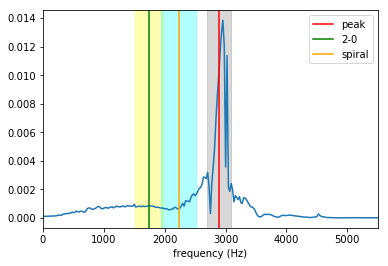

_____________________________________________________
data/BAM:0126.h5


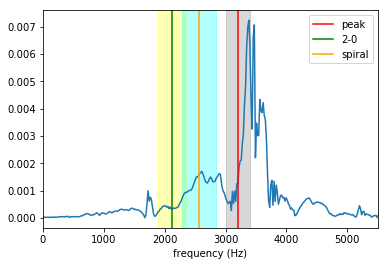

_____________________________________________________
data/BAM:0128.h5


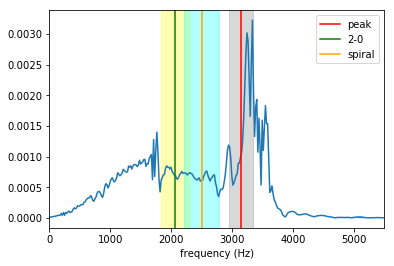

_____________________________________________________


In [22]:

for i in range(len(BAM)):
    name = 'data/BAM:0'+BAM[i]+'.h5' 
    print(name)
    file=h5py.File(name,'r')
    dat = list(file["/rh_22"])
    rh = np.array(file["/rh_22/%s" %dat[-1]])
    freq,amp,time,dat,fig1=analyze(rh,mas2[i])
    ax=plt.subplot()
    ax.axvline(x=(f_p_a[i]*Mc[i])*1000,color='r',label='peak')
    ax.axvspan((f_p_a[i]*Mc[i])*1000-196, (f_p_a[i]*Mc[i])*1000+196, alpha=0.3, color='grey')
    ax.axvline(x=(f_2_a[i]*Mc[i])*1000,color='g',label='2-0')
    ax.axvspan((f_2_a[i]*Mc[i])*1000-229, (f_2_a[i]*Mc[i])*1000+229, alpha=0.3, color='yellow')
    ax.axvline((f_s_a[i]*Mc[i])*1000,color='orange',label='spiral') 
    ax.axvspan((f_s_a[i]*Mc[i])*1000-286, (f_s_a[i]*Mc[i])*1000+286, alpha=0.3, color='cyan')
    plt.xlabel('frequency (Hz)')
    plt.legend()
    plt.show()
    print('_____________________________________________________')
    

data/BAM:0002.h5


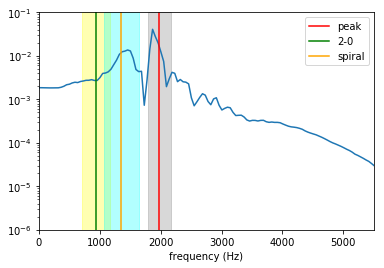

_____________________________________________________
data/BAM:0003.h5


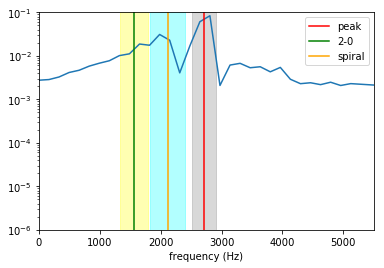

_____________________________________________________
data/BAM:0004.h5


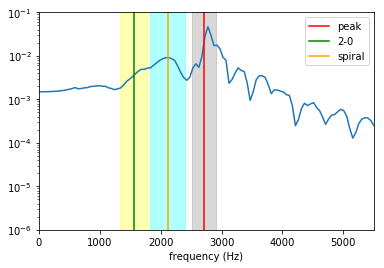

_____________________________________________________
data/BAM:0009.h5


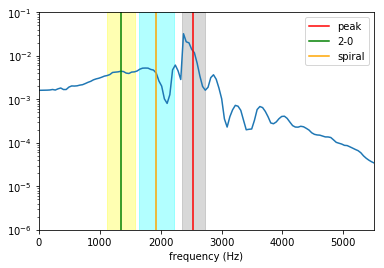

_____________________________________________________
data/BAM:0010.h5


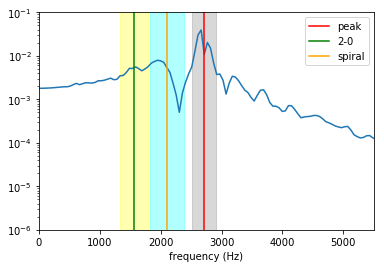

_____________________________________________________
data/BAM:0022.h5


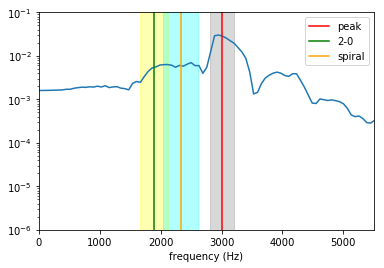

_____________________________________________________
data/BAM:0035.h5


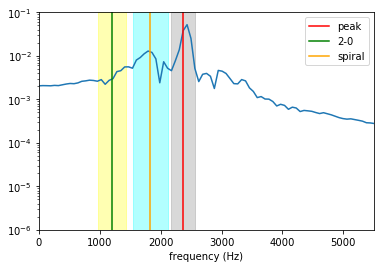

_____________________________________________________
data/BAM:0036.h5


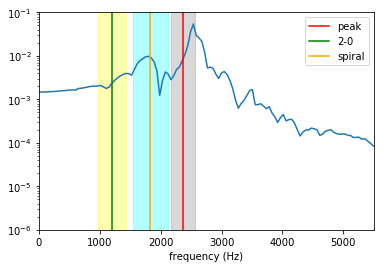

_____________________________________________________
data/BAM:0046.h5


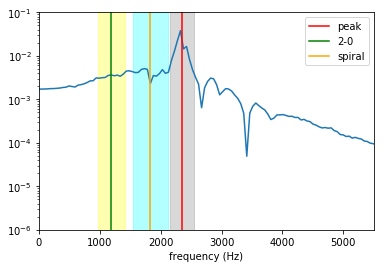

_____________________________________________________
data/BAM:0048.h5


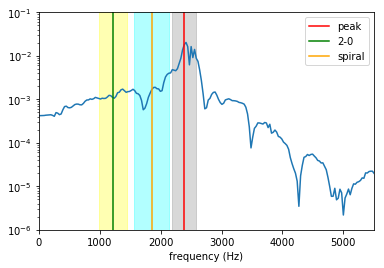

_____________________________________________________
data/BAM:0053.h5


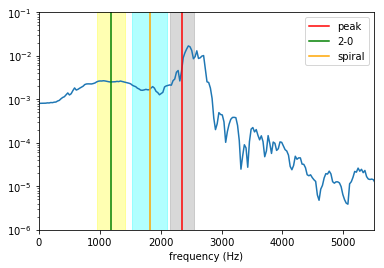

_____________________________________________________
data/BAM:0057.h5


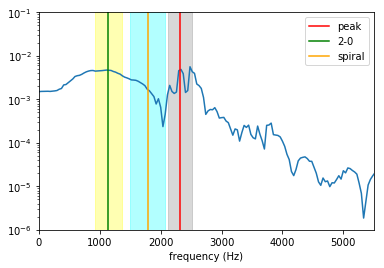

_____________________________________________________
data/BAM:0058.h5


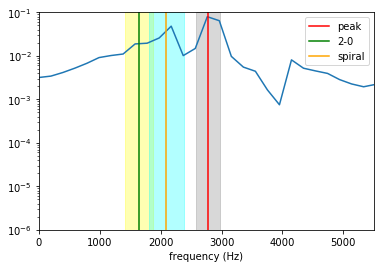

_____________________________________________________
data/BAM:0059.h5


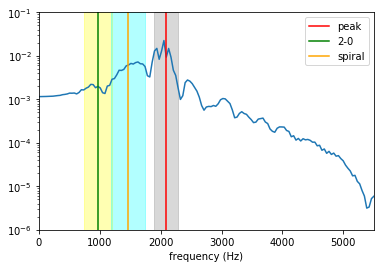

_____________________________________________________
data/BAM:0061.h5


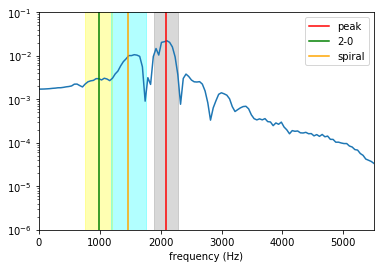

_____________________________________________________
data/BAM:0065.h5


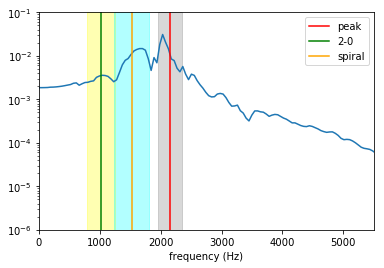

_____________________________________________________
data/BAM:0070.h5


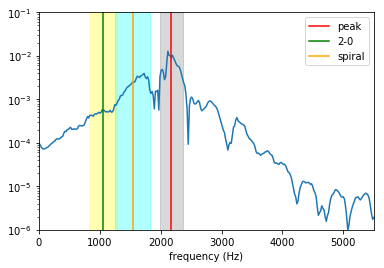

_____________________________________________________
data/BAM:0080.h5


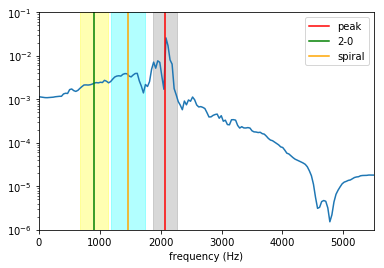

_____________________________________________________
data/BAM:0089.h5


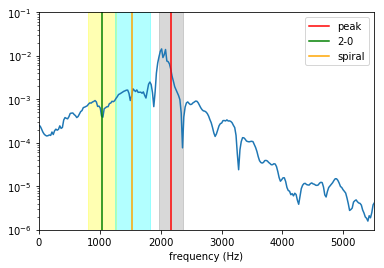

_____________________________________________________
data/BAM:0090.h5


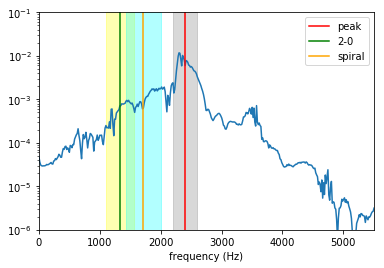

_____________________________________________________
data/BAM:0091.h5


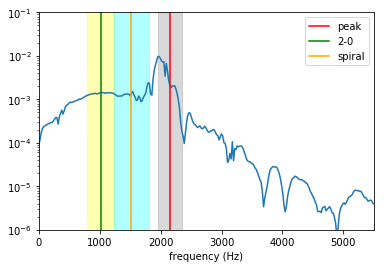

_____________________________________________________
data/BAM:0092.h5


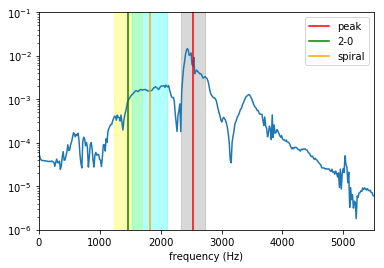

_____________________________________________________
data/BAM:0093.h5


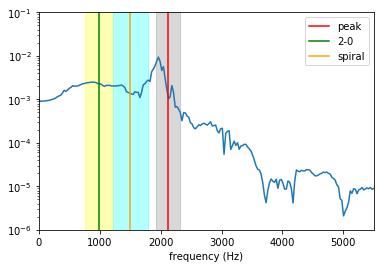

_____________________________________________________
data/BAM:0098.h5


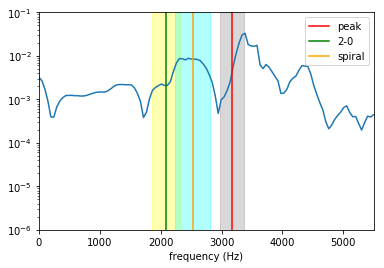

_____________________________________________________
data/BAM:0107.h5


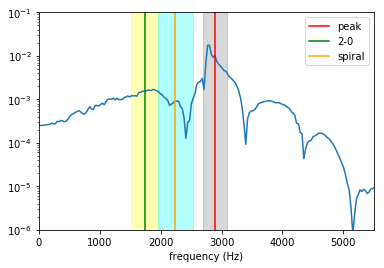

_____________________________________________________
data/BAM:0121.h5


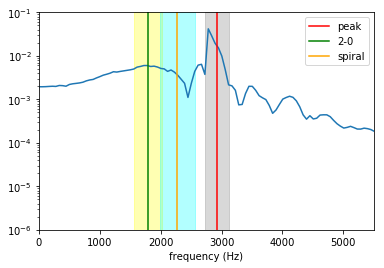

_____________________________________________________
data/BAM:0122.h5


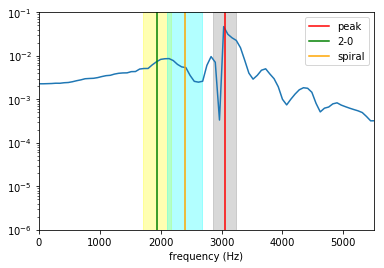

_____________________________________________________
data/BAM:0123.h5


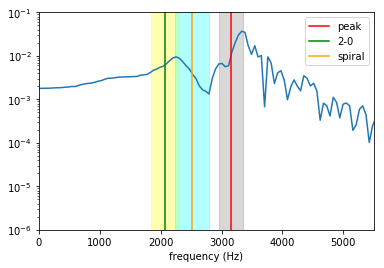

_____________________________________________________
data/BAM:0124.h5


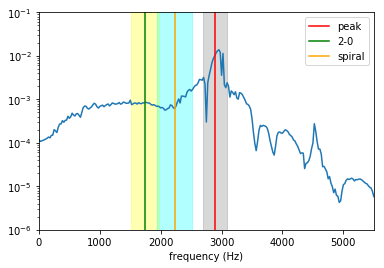

_____________________________________________________
data/BAM:0126.h5


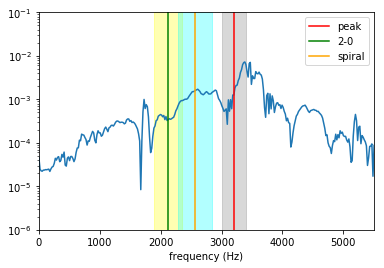

_____________________________________________________
data/BAM:0128.h5


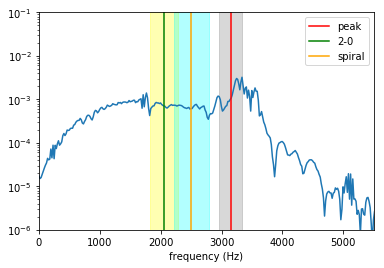

_____________________________________________________


In [23]:

for i in range(len(BAM)):
    name = 'data/BAM:0'+BAM[i]+'.h5' 
    print(name)
    file=h5py.File(name,'r')
    dat = list(file["/rh_22"])
    rh = np.array(file["/rh_22/%s" %dat[-1]])
    freq,amp,time,dat,fig1=analyze(rh,mas2[i])
    ax=plt.subplot()
    ax.axvline(x=(f_p_a[i]*Mc[i])*1000,color='r',label='peak')
    ax.axvspan((f_p_a[i]*Mc[i])*1000-196, (f_p_a[i]*Mc[i])*1000+196, alpha=0.3, color='grey')
    ax.axvline(x=(f_2_a[i]*Mc[i])*1000,color='g',label='2-0')
    ax.axvspan((f_2_a[i]*Mc[i])*1000-229, (f_2_a[i]*Mc[i])*1000+229, alpha=0.3, color='yellow')
    ax.axvline((f_s_a[i]*Mc[i])*1000,color='orange',label='spiral') 
    ax.axvspan((f_s_a[i]*Mc[i])*1000-286, (f_s_a[i]*Mc[i])*1000+286, alpha=0.3, color='cyan')
    plt.xlabel('frequency (Hz)')
    plt.legend()
    plt.yscale('log')
    plt.ylim(10**(-6),10**(-1))
    plt.show()
    print('_____________________________________________________')
    